# **Time Series Forecasting con XGBoost**
En este notebook, realizaremos un análisis y predicción de series de tiempo utilizando XGBoost.
 
## **Objetivo:**
Predecir el consumo de energía en megavatios (MW) a partir de datos históricos.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,root_mean_squared_error

import xgboost as xgb
import shap
import lime
import lime.lime_tabular

# Configuración de estilo
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


 ## **¿Qué es una serie de tiempo?**

Una serie de tiempo es una secuencia de datos recolectados en intervalos de tiempo regulares.
Algunos ejemplos incluyen datos de temperatura, precios de acciones y consumo de energía.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*TLntcCZE8KBKE4QACbRoaw.png)


## **Tipos de Series de Tiempo**

- **Estacionarias**: La media y la varianza son constantes en el tiempo.
- **No estacionarias**: Presentan tendencias o estacionalidad.

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)
    


## **Carga y exploración de datos**
Cargamos el dataset de consumo de energía y establecemos la columna 'Datetime' como índice temporal.

In [62]:
df = pd.read_csv('data/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)


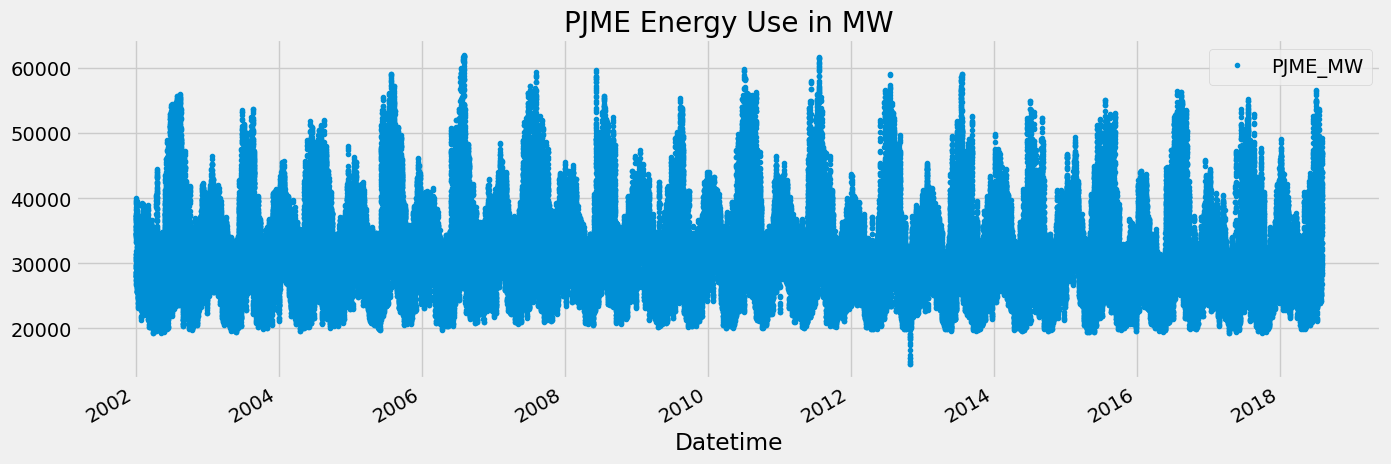

In [63]:
# Visualizamos la serie de tiempo completa.

df.plot(style='.', figsize=(15, 5), color=color_pal[0], title='PJME Energy Use in MW')
plt.show()


## **Train / Test Split**
Dividimos los datos en conjunto de entrenamiento (hasta 2014) y conjunto de prueba (a partir de 2015).

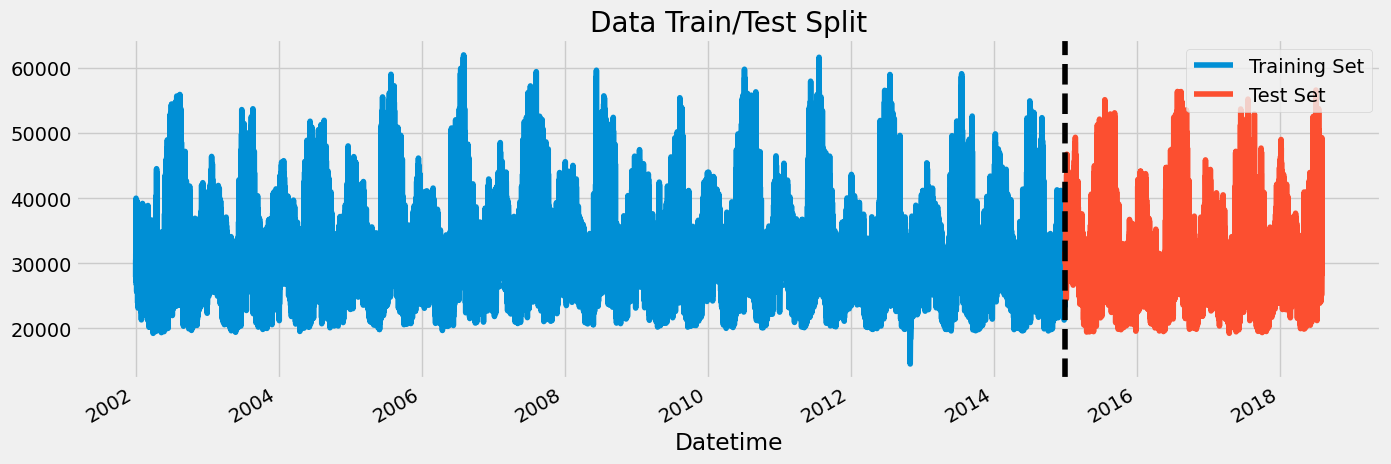

In [64]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()



## **Feature Engineering**
Creamos nuevas características basadas en la fecha y hora para mejorar la capacidad predictiva del modelo.


In [65]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## **Análisis exploratorio**
Visualizamos cómo varía el consumo de energía a lo largo del día y del mes.

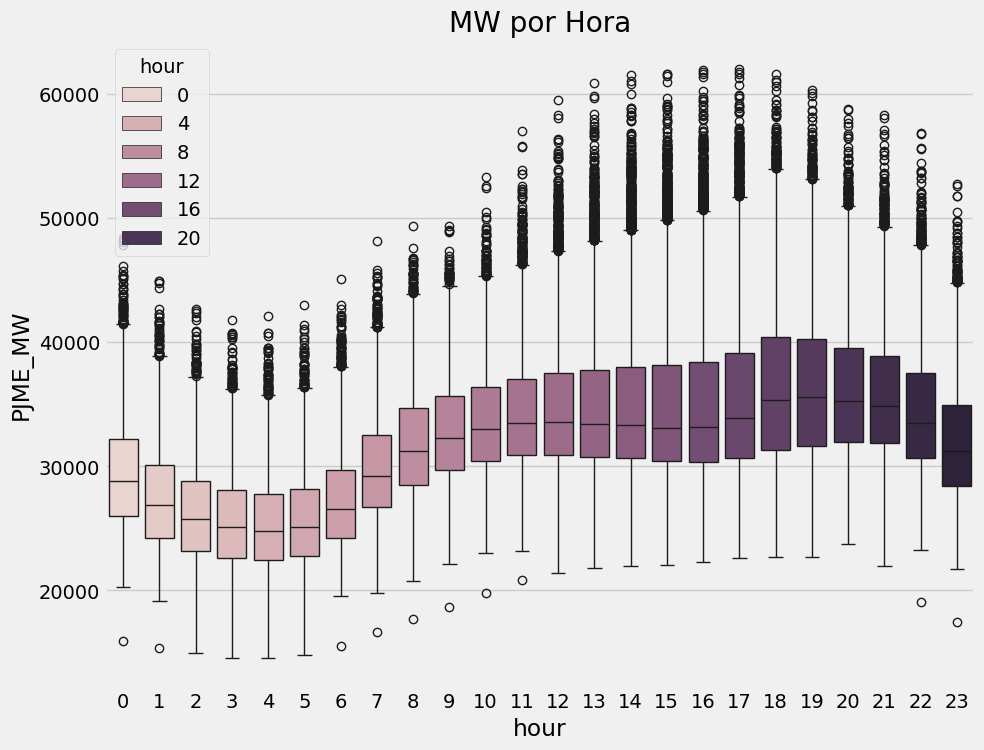

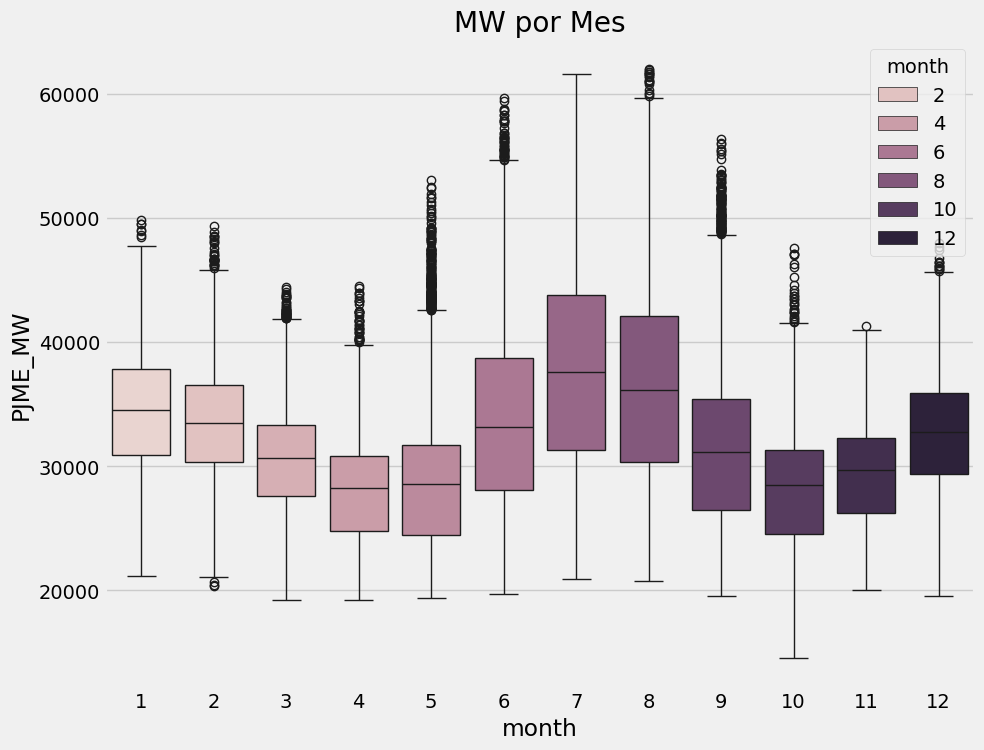

In [66]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW',hue='hour')
ax.set_title('MW por Hora')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW',hue='month')
ax.set_title('MW por Mes')
plt.show()

## **Entrenamiento del modelo XGBoost**

XGBoost (**Extreme Gradient Boosting**) es una biblioteca de aprendizaje automático optimizada y diseñada para ser altamente eficiente en términos de velocidad y rendimiento. Es un algoritmo basado en árboles de decisión que utiliza el método de gradient boosting, el cual construye modelos secuenciales donde cada nuevo árbol intenta corregir los errores del anterior

In [67]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

base_re = xgb.XGBRegressor(random_state=42)
base_re.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)



[0]	validation_0-rmse:5179.23300	validation_1-rmse:5359.30943
[99]	validation_0-rmse:1676.77305	validation_1-rmse:4193.15520


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

100%|===================| 31346/31440 [01:41<00:00]        

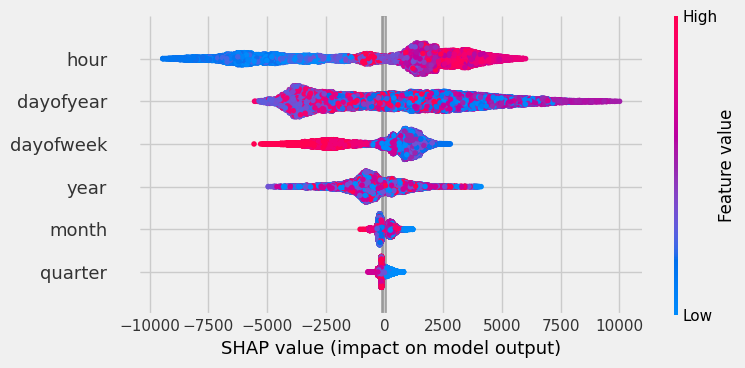

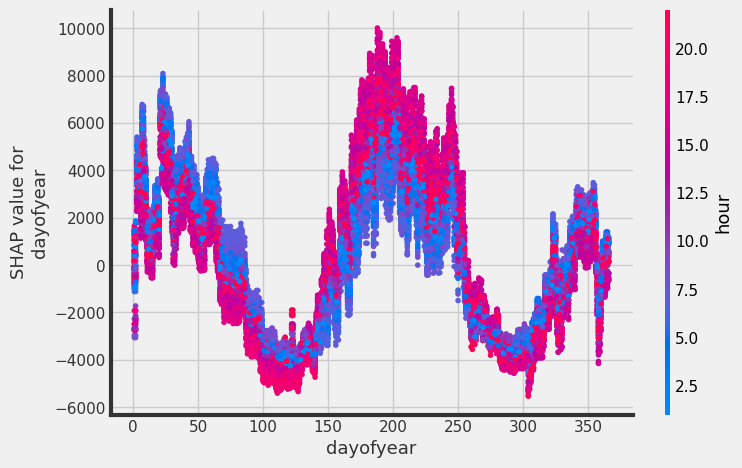

In [68]:
# Predicciones
y_pred = base_re.predict(X_test)

#  SHAP Analysis

explainer = shap.Explainer(base_re, X_train)  # Crear explicador SHAP
shap_values = explainer(X_test)  # Obtener valores SHAP para el conjunto de prueba

# 🔹 Gráfico de importancia de características con SHAP
shap.summary_plot(shap_values, X_test)

# 🔹 Dependencia parcial de una característica específica
shap.dependence_plot(0, shap_values.values, X_test)   # Cambia el índice para otra variable

In [69]:
#  LIME Analysis

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train), 
    mode="regression",
    feature_names=X_train.columns
)

# Elegimos una instancia aleatoria para explicar
idx = np.random.randint(0, X_test.shape[0])  # Seleccionar aleatoriamente un punto
sample = np.array(X_test.iloc[idx])

# Generamos la explicación con LIME
exp = explainer_lime.explain_instance(sample, base_re.predict, num_features=5)

# 🔹 Visualizamos la explicación de LIME
exp.show_in_notebook()


## **Importancia de las características**

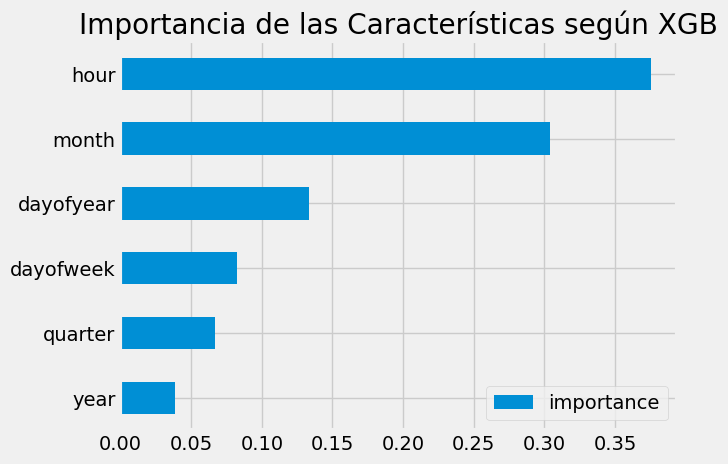

In [70]:
fi = pd.DataFrame(data=base_re.feature_importances_, index=base_re.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Importancia de las Características según XGB')
plt.show()

## **Predicciones y evaluación del modelo**


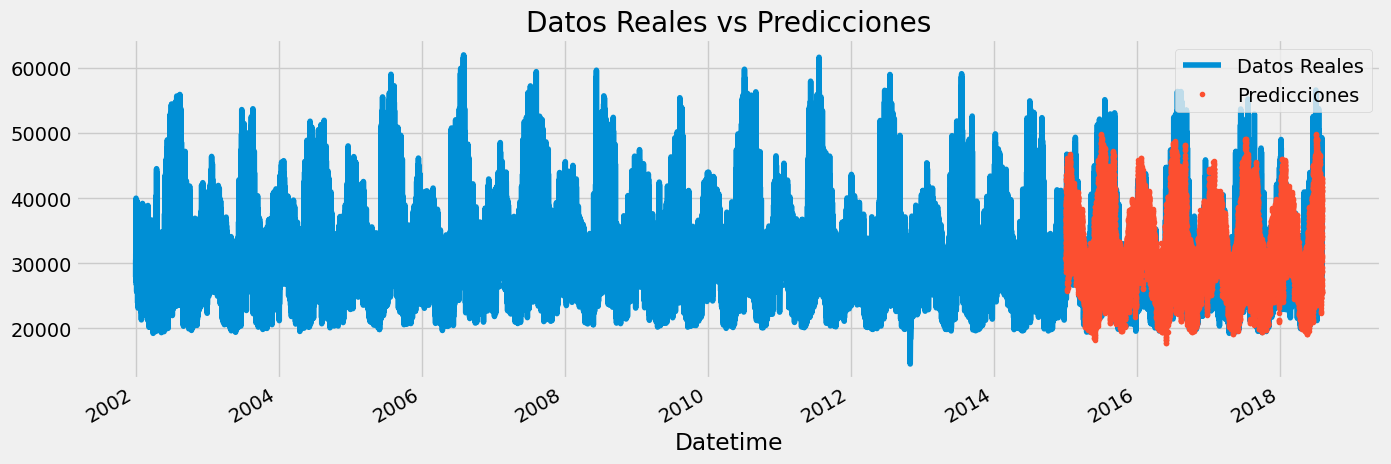

In [71]:
test['base_prediction'] = base_re.predict(X_test)
df = df.merge(test[['base_prediction']], how='left', left_index=True, right_index=True)

ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['base_prediction'].plot(ax=ax, style='.')
plt.legend(['Datos Reales', 'Predicciones'])
ax.set_title('Datos Reales vs Predicciones')
plt.show()


In [72]:
# **Métrica de error (RMSE)**
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['base_prediction']))
print(f'RMSE en el conjunto de prueba: {score:0.2f}')


RMSE en el conjunto de prueba: 4193.16


## **Aplicamos un Random forest**

In [73]:
#Entrenamos una versión sencilla de RF
rf=RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Random Forest MSE = {mse_rf:.4f}")
print(f"Random Forest RMSE = {rmse_rf:.4f}")

Random Forest MSE = 18835522.7686
Random Forest RMSE = 4339.9911


### **Analizamos su feature importance**

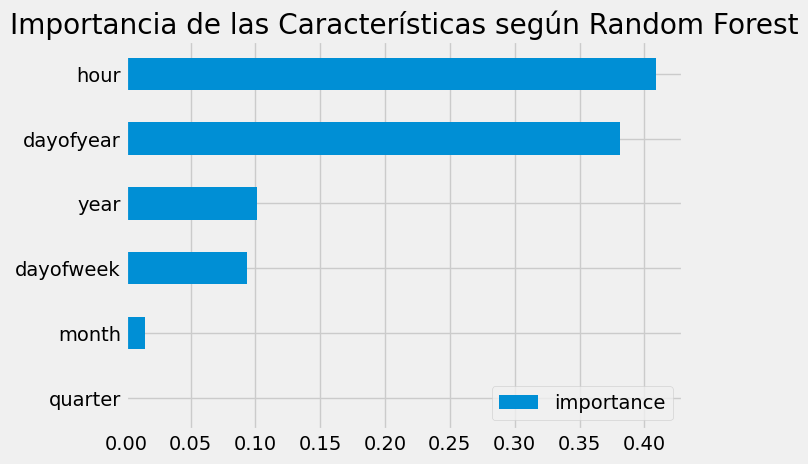

In [74]:
fi = pd.DataFrame(data=rf.feature_importances_, index=rf.feature_names_in_, columns=['importance'])
ax = fi.sort_values('importance').plot(kind='barh', title='Importancia de las Características según Random Forest')

# Mover la leyenda a la esquina superior derecha
ax.legend(loc='lower right')

plt.show()


In [75]:
from sklearn.model_selection import GridSearchCV

# Definir el grid de hiperparámetros a probar
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Número de árboles
#     'max_depth': [None, 10, 20],  # Profundidad máxima
#     'min_samples_split': [2, 5, 8],  # Mínimo de muestras para dividir un nodo
#     'min_samples_leaf': [1, 2, 4]  # Mínimo de muestras en cada hoja
# }
# Para efectos prácticos vamos a reducir las opciones del grid para procesar rápido
param_grid = {
    'n_estimators': [100],  # Número de árboles
    'max_depth': [ 10, 20],  # Profundidad máxima
    'min_samples_split': [2, 4],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [ 3, 4]  # Mínimo de muestras en cada hoja
}

# Aplicar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_rf = grid_search.best_estimator_

# Predicciones y evaluación
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Random Forest Best MSE = {mse_rf:.4f}")
print(f"Random Forest Best RMSE = {rmse_rf:.4f}")

# Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Best MSE = 14932038.9770
Random Forest Best RMSE = 3864.1997


## **Optimizando hiperparámetros de XGB con GridSearch**

In [76]:
# Grid Search para optimización de hiperparámetros
param_grid = {
    'n_estimators': [100, 500],#Número de árboles que se construirán.
    'max_depth': [3, 5, 7],# Profundidad máxima de los árboles. Controla la complejidad de cada árbol.
    'learning_rate': [ 0.01,0.03, 0.05],#Tasa de aprendizaje, que controla la magnitud de los ajustes realizados en cada iteración.
    # 'subsample':[0.5,0.7,0.9],#Fracción de las muestras que se utilizarán para entrenar cada árbol'
    'early_stopping_rounds':[10]#Número de iteraciones sin mejora en la métrica de validación después de las cuales el entrenamiento se detendrá automáticamente
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',random_state=42)# Define la función de pérdida que se utilizará para la optimización.
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

best_params = grid_search.best_params_
print(f'Mejores hiperparámetros: {best_params}')


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[0]	validation_0-rmse:6405.35485	validation_1-rmse:6478.73472
[1]	validation_0-rmse:6359.02052	validation_1-rmse:6436.03429
[2]	validation_0-rmse:6313.33985	validation_1-rmse:6394.28992
[3]	validation_0-rmse:6268.25231	validation_1-rmse:6352.88463
[4]	validation_0-rmse:6223.64997	validation_1-rmse:6312.27413
[5]	validation_0-rmse:6179.69001	validation_1-rmse:6272.03551
[6]	validation_0-rmse:6136.28687	validation_1-rmse:6232.56990
[7]	validation_0-rmse:6093.42184	validation_1-rmse:6193.47038
[8]	validation_0-rmse:6051.04836	validation_1-rmse:6155.05661
[9]	validation_0-rmse:6009.34582	validation_1-rmse:6117.08341
[10]	validation_0-rmse:5968.12332	validation_1-rmse:6079.90996
[11]	validation_0-rmse:5927.38981	validation_1-rmse:6042.93613
[12]	validation_0-rmse:5887.21663	validation_1-rmse:6006.71640
[13]	validation_0-rmse:5847.51006	validation_1-rmse:5970.97590
[14]	validation_0-rmse:5808.28769	validation_1-rmse:5935.90639
[15]

Mejores hiperparámetros: {'early_stopping_rounds': 10, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}


[0]	validation_0-rmse:6405.35485	validation_1-rmse:6478.73472
[100]	validation_0-rmse:3785.87609	validation_1-rmse:4249.04040
[200]	validation_0-rmse:3097.07093	validation_1-rmse:3837.25581
[281]	validation_0-rmse:2873.37474	validation_1-rmse:3775.82811


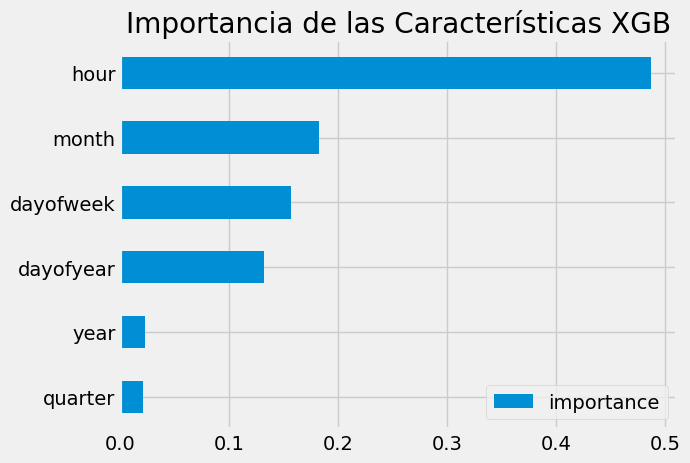

In [77]:
# Entrenamiento del modelo optimizado
reg = xgb.XGBRegressor(**best_params,random_state=42)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

# Importancia de las características
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Importancia de las Características XGB')
plt.show()


In [78]:
# Predicciones modelo optimizado
test['optimized_prediction'] = reg.predict(X_test)
df = df.merge(test[[ 'optimized_prediction']], how='left', left_index=True, right_index=True)


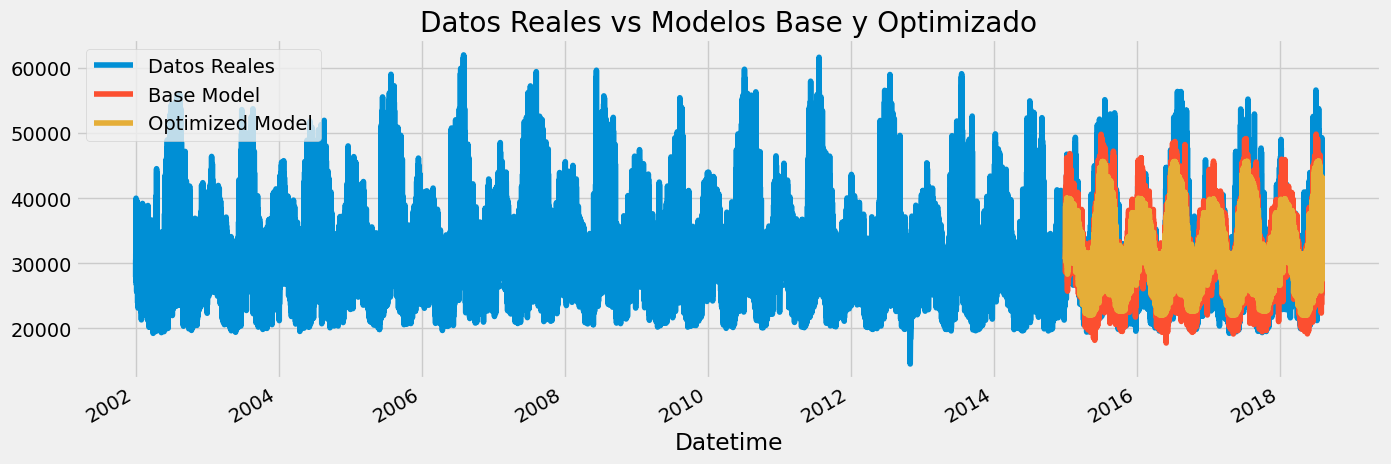

In [79]:
# Visualización del modelo optimizado
ax = df['PJME_MW'].plot(figsize=(15, 5))
df['base_prediction'].plot(ax=ax)
df['optimized_prediction'].plot(ax=ax )
plt.legend(['Datos Reales', 'Base Model', 'Optimized Model'])
ax.set_title('Datos Reales vs Modelos Base y Optimizado')
plt.show()


In [80]:
# Evaluación del modelo optimizado
optimized_score = np.sqrt(mean_squared_error(test['PJME_MW'], test['optimized_prediction']))
print(f'RMSE modelo optimizado: {optimized_score:0.2f}')

RMSE modelo optimizado: 3774.11


### **Probamos un boosting...**

In [81]:

# Evaluación para Boosting
boosting_model = GradientBoostingRegressor(n_estimators=50, random_state=42,loss='squared_error',learning_rate=0.05)
boosting_model.fit(X_train, y_train)
y_pred_boosting = boosting_model.predict(X_test)
mse_boosting = mean_squared_error(y_test, y_pred_boosting)
print(f"Boosting MSE = {mse_boosting:.4f}")
rmse=np.sqrt(mse_boosting)
print(f"Boosting (Random Forest) RMSE = {rmse:.4f}")

Boosting MSE = 17302389.8857
Boosting (Random Forest) RMSE = 4159.6142


### **Probamos un Stacking...**

In [82]:
# Evaluación para Stacking
stacking_model = StackingRegressor(
    estimators=[('rf', RandomForestRegressor(random_state=42)), ('gb', GradientBoostingRegressor(random_state=42))], 
    final_estimator=LinearRegression())
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
print(f"Stacking MSE = {mse_stacking:.4f}")
rmse=np.sqrt(mse_stacking)
print(f"Boosting (Random Forest) RMSE = {rmse:.4f}")


Stacking MSE = 13793275.4896
Boosting (Random Forest) RMSE = 3713.9299


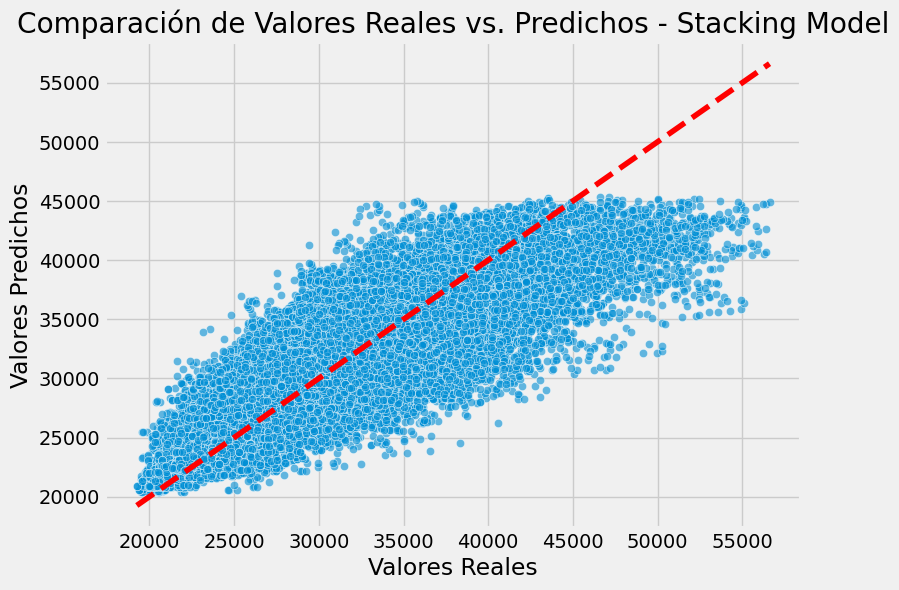

In [83]:
# Graficar valores reales vs predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_stacking, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Línea de referencia

# Etiquetas y título
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Comparación de Valores Reales vs. Predichos - Stacking Model")
plt.grid(True)

# Mostrar gráfico
plt.show()